In [1]:
import numpy
import pandas
import sys
from pathlib import Path
import requests
import site
from subprocess import check_call, run
from matplotlib import pyplot, cm

In [2]:
kallisto_git = Path('/content/kallisto').expanduser()
if not kallisto_git.exists():
  !apt update
  !apt install -y cmake
  !apt-get install autoconf
  !git clone https://github.com/pachterlab/kallisto.git
kallisto_build = kallisto_git / 'build'
if not kallisto_build.exists():
  kallisto_build.mkdir()
kallisto_exe = kallisto_build / 'src' / 'kallisto'
if not kallisto_exe.exists():
  !pushd kallisto/build && cmake .. && make && popd
  !chmod +x kallisto/build/src/kallisto

In [3]:
single_cell_qc = Path(site.getsitepackages()[0]) / 'singleqc'
if not single_cell_qc.exists():
  !python3 -m pip install git+https://github.com/detrout/single-cell-qc

In [4]:
def DownloadFile(url, local_filename):
    r = requests.get(url)
    f = open(local_filename, 'wb')
    for chunk in r.iter_content(chunk_size=512 * 1024): 
        if chunk: # filter out keep-alive new chunks
            f.write(chunk)
    f.close()
    return 

In [5]:
def sc_scatter(kallisto, rsem, cell_id, ax=None):
    gridalpha = 0.5
    def is_spike(x):
        if x.startswith('gSpikein_') or x.startswith('tSpikein_'):
            return True
        else:
            return False

    if ax is None:
        f = pyplot.figure()
        ax = f.subplots(1,1)
    
    set1 = cm.get_cmap('Set1').colors
    colors = [{True: set1[0], False: set1[1]}[is_spike(x)] for x in kallisto.index]

    ax.plot([-5,10], [-5,10], c=set1[2])
    #x_cells = numpy.asarray(table[name_x][cell_id].X.todense())
    #y_cells = numpy.asarray(table[name_y][cell_id].X.todense())
    ax.scatter(kallisto+0.01, rsem+0.01, color=colors, s=2)
    count = numpy.sum((kallisto > 0) & (rsem > 0))
    ax.set_title(f'id {cell_id}\nCount: {count}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('kallisto')
    ax.set_ylabel('rsem')
    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = gridalpha)


In [6]:
genome_root = Path('genome')
if not genome_root.exists():
  genome_root.mkdir()

genome_mm10_minimal = genome_root / 'mm10-M21_minimal-male'
if not genome_mm10_minimal.exists():
  genome_mm10_minimal.mkdir()

genome_mm10_encode = genome_root / 'mm10-M21-male'
if not genome_mm10_encode.exists():
  genome_mm10_encode.mkdir()

index_mm10_minimal = genome_mm10_minimal / 'mm10-M21_minimal-male-kallisto-0.46.2.idx'
if not index_mm10_minimal.exists():
  DownloadFile(
      'https://woldlab.caltech.edu/~diane/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/mm10-M21_minimal-male/mm10-M21_minimal-male-kallisto-0.46.2.idx',
      index_mm10_minimal
  )

In [7]:

ercc_fa = genome_root / 'ENCFF01RTP.fastq.gz'
if not ercc_fa.exists():
  DownloadFile(
      'https://www.encodeproject.org/files/ENCFF001RTP/@@download/ENCFF001RTP.fasta.gz',
      ercc_fa)
  
phix_fa = genome_root / 'ENCFF335FFV.fasta.gz'
if not phix_fa.exists():
  DownloadFile(
    'https://www.encodeproject.org/files/ENCFF335FFV/@@download/ENCFF335FFV.fasta.gz',
    phix_fa
  )

In [8]:
fastq_root = 'https://woldlab.caltech.edu/~diane/C1_mouse_limb_timecourse/'
fastqs = [
        '18089_H4/18089_H4_TCCTGAGC-CTAAGCCT_L001_R1_001.fastq.gz',
        '18089_H4/18089_H4_TCCTGAGC-CTAAGCCT_L002_R1_001.fastq.gz',
        '18273_D5/18273_D5_TACGCTGC-GCGTAAGA_L001_R1_001.fastq.gz',
        '18273_D5/18273_D5_TACGCTGC-GCGTAAGA_L002_R1_001.fastq.gz',
        '19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz',
        '19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz',
]

for filename in fastqs:
  path = Path(filename)
  if not path.parent.exists():
    path.parent.mkdir()
  if not path.exists():
    print('Downloading {}'.format(path))
    DownloadFile(fastq_root + filename, path)

In [13]:
fastqs_by_library = {}
for filename in fastqs:
  path = Path(filename)
  fastqs_by_library.setdefault(str(path.parent), []).append(filename)

In [11]:
!$kallisto_exe quant -i $index_mm10_minimal \
   -o 19908_C1/cdna \
   --single --fragment-length=1759.25 --sd=1103.91775 \
   19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz


[quant] fragment length distribution is truncated gaussian with mean = 1759.25, sd = 1103.92
[index] k-mer length: 31
[index] number of targets: 115,440
[index] number of k-mers: 105,021,148
tcmalloc: large alloc 3221225472 bytes == 0x557dde058000 @  0x7efd919bb887 0x557ddbfadad2 0x557ddbfa6061 0x557ddbf7b04a 0x7efd9083bbf7 0x557ddbf7f0da
[index] number of equivalence classes: 391,234
[quant] running in single-end mode
[quant] will process file 1: 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L001_R1_001.fastq.gz
[quant] will process file 2: 19908_C1/19908_C1_TAAGGCGA-GTAAGGAG_L002_R1_001.fastq.gz
[quant] finding pseudoalignments for the reads ... done
[quant] processed 1,659,329 reads, 486,608 reads pseudoaligned
[   em] quantifying the abundances ... done
[   em] the Expectation-Maximization algorithm ran for 833 rounds



In [17]:
def run_kallisto(target, fastqs, fragment_length):
  filenames = ' '.join(fastqs[target])
  sd = 0.1 * fragment_length
  !$kallisto_exe quant -i $index_mm10_minimal \
    -o $target/f$fragment_length \
    --single --fragment-length=$fragment_length --sd=$sd \
   $filenames

In [34]:
fragment_lengths = [100, 200, 300, 400, 500, 600]

In [33]:
for length in fragment_lengths:
  run_kallisto('19908_C1', fastqs_by_library, length)

NameError: ignored

In [19]:
def load_kallisto(filename, column):
    assert column in ['length', 'est_counts', 'tpm']
    spike_prefix = 'tSpikein_'
    spike_prefix_len = len(spike_prefix)
    df = pandas.read_csv(
        filename,
        sep='\t',
        #converters={'target_id': lambda x: x[spike_prefix_len:] if x.startswith('tSpikein_') else x}
    )
    return df.set_index('target_id')[column]

In [27]:
quants = {}
for length in fragment_lengths:
  target = Path('19908_C1') / "f{length}".format(length=length) / 'abundance.tsv'
  abundance = pandas.read_csv(target, sep='\t')
  quants[length] = abundance.set_index('target_id')


In [28]:
q = quants[100]

In [36]:
def hist_the_lengths(quants, length, ax):
  quants[length][quants[length]['est_counts'] > 0]['length'].plot.hist(bins=1000, ax=ax)

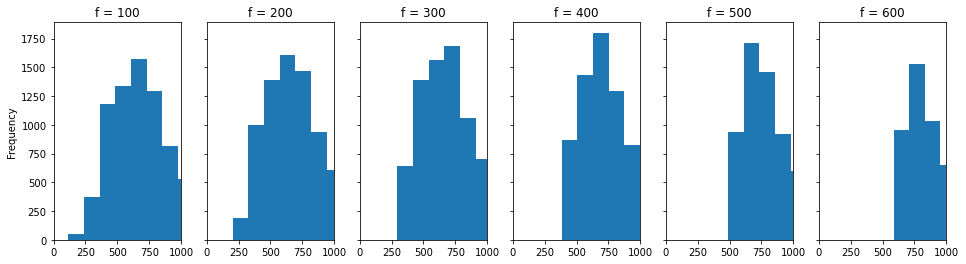

In [49]:
f = pyplot.figure(figsize=(16,4))
axes = f.subplots(1,len(fragment_lengths), sharex=True, sharey=True)
for i, length in enumerate(fragment_lengths):
  hist_the_lengths(quants, length, axes[i])
  axes[i].set_title('f = {}'.format(length))
  axes[i].set_xlim(0, 1000)


In [44]:
a = axes[0]

In [ ]:
a.set_xl